# SLT-CE-3: Deterministic Annealing

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Deterministic annealing for clustering, compression, classification, regression, and related optimization
problems, Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/
</li>
    
<li>
A Ratio Scale Metric and the Compatibility
of Ratio Scales: The Possibility of
Arrow’s Impossibility Theorem, T.L. Saalty, 1994, https://www.sciencedirect.com/science/article/pii/0893965994900930
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
<li>
Lecture 3, slide 19, https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture03.pdf
</li>
    
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure to install treelib in the slt-ce conda environment: conda install treelib
import treelib as tl
from treelib import Node, Tree
from sklearn.manifold import TSNE, LocallyLinearEmbedding

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import KMeans
import random

<h2 style="background-color:#f0b375;">
Section Preliminary
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 0.0 </span>
</h2>

<p style="background-color:#adebad;">
    Implement the function read_X_y_from_csv according to the contract in its docstring.
</p>

In [2]:
def read_X_y_from_csv(sheet, y_names=None):
    """Parse a column data store into X, y arrays

    Args:
        sheet (str): Path to csv data sheet.
        y_names (list of str): List of column names used as labels.

    Returns:
        X (np.ndarray): Array with feature values from columns that are not contained in y_names (n_samples, n_features)
        y (dict of np.ndarray): Dictionary with keys y_names, each key contains an array (n_samples, 1)
                                with the label data from the corresponding column in sheet. 
    """

    data = pd.read_csv(sheet)    
    all_cols = list(data)
    x_names = list(set(all_cols) - set(y_names))
    X = data.loc[:, x_names].values
    
    y = {}
    for key in y_names:
        ys = data.loc[:, key].values
        y[key] = ys
    
    return X, y

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

In [3]:
X, y = read_X_y_from_csv("wine-data.csv", y_names=["quality", "color"])

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.0 </span>
</h2>

<p style="background-color:#adebad;">
    Read reference [1] about deterministic annealing clustering (DAC). Shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

Author refers to the mass-constrained clustering as the preferred implementation of the DAC algorithm in the paper. Mass-constrained clustering introduces weighting of the centroids, which leads to solving an expectation-maximization (EM) procedure for Gaussian mixtures for a fixed temperature. Here, we only provide new centroids if deemed necessary, which leads to keeping only an effective number of clusters for a given T. Monitoring the critical temperatures for cluster births are managed by first calculating the covariance of posterior distribution for a given centroid and then extracting the largest eigenvector of that matrix (see function crit_temp). Authors further state that *"phase transitions occur as the temperature is lowered to twice the variance along the principal axis of the cluster"*.  
Lines of the pseudocode from the algorithm is specified alongside the below implementation. We first initialize the variables, where we also calculate the initial temperature through the critical temperature of the original cluster. Then for each temperature through the cooling process we run an EM procedure to obtain cluster centers, cluster weights and the assignment probabilities of the data points. We reduce the temperature and check for the critical temperature condition. The loop is iterated until we reach a specified cutoff temperature, which leads to the last calculation for zero temperature. Our objective is to find the *"hard clustering solution for a given number of clusters"*.

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>

In [4]:
class DeterministicAnnealingClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for DAC
    
    Attributes:
        cluster_centers_ (np.ndarray): Cluster centroids y_i (n_clusters, n_features)
        cluster_probabs_ (np.ndarray): Assignment probability vectors p(y_i | x) for each sample
                                       (n_samples, n_clusters)
        bifurcation_tree_ (treelib.Tree): Tree object that contains information about cluster evolution during
                                          annealing.
                                       
    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """
    
    def __init__(self, n_clusters=8, random_state=42, metric="euclidian",
                T_cutoff=0.1, eta=0.98, epsilon=0.1, T_0=1e-5, verbose=False, trials=1):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        # Add more parameters, if necessary.
        self.T_cutoff = T_cutoff
        self.eta = eta
        self.epsilon = epsilon
        self.T_0 = T_0
        self.verbose = verbose
        self.trials = trials

    # Splits the kth centroid in the bifurcation tree
    def split_tree(self, k):
        k_now = len(self.bifurcation_tree_.leaves())
        pid = [x.identifier for x in self.bifurcation_tree_.leaves() if x.tag == k][0]
        id_end = str(int(pid.split('_')[-1])+1)
        self.bifurcation_tree_.create_node(k, str(k)+'_'+id_end, parent=pid)
        self.bifurcation_tree_.create_node(k_now, str(k_now)+'_'+id_end, parent=pid)

    # Calculates the distortion and the free energy
    def calc_D_E(self, X, num_centroids):
        T = self.T_cutoff
        n_samples = X.shape[0]
        p_x = 1.0 / n_samples
        dists = np.array([np.linalg.norm(X - self.cluster_centers_[k], axis=1)**2 / T for k in range(num_centroids)])
        joint = self.cluster_probabs_ * p_x
        D = np.sum(joint * np.moveaxis(dists, 0, 1))
        H = -np.sum(joint * np.log(joint + 1e-8))
        E = D - H * T
        return D, E

    # Calculates the critical temperature for a given cluster
    def crit_temp(self, X, k, p_x):
        mask = np.array(self.cluster_probabs_.max(axis=1,keepdims=1) == self.cluster_probabs_, dtype=int)
        mask = mask[:,k]
        diffs = np.moveaxis(X - self.cluster_centers_[k], 0, 1)
        diffs = diffs * np.sqrt(self.cluster_probabs_[:,k])
        diffs = diffs * mask
        covar = np.matmul(diffs, diffs.T)
        covar = covar * p_x / self.py_list[k,:]
        w, v = np.linalg.eigh(covar)
        T_c = 2 * np.max(w)
        return T_c
    
    # Plots the phase diagram of the cooling process
    def phase_diagram(self):
        t = np.log(np.min(self.temp) / self.temp)
        d = np.log(self.distortion / np.min(self.distortion))
        plt.figure(figsize=(17,4))
        plt.plot(t, d, 'b-', lw=2)
        for st in self.split_t:
            ts = np.log(np.min(DAC.temp) / st)
            plt.plot([ts, ts], [0, np.max(d)], 'k--', lw=1)
        plt.ylabel(r'$\log[<D> / <D>_{min} ]$')
        plt.xlabel(r'$\log[\beta / \beta_{min} ]$')
        plt.title('Phase diagram')
        plt.show()
 
    # Fit the data multiple times and keep the best result      
    def fit(self, X):

        if self.trials > 1:
            best_energy = np.inf
            for rs in range(self.trials):
                self._fit(X)
                results = (self.free_energy, self.cluster_centers_, self.cluster_probabs_,
                           self.distortion, self.n_eff_clusters, self.temp, self.split_t, 
                           self.py_list, self.bifurcation_tree_)
                if results[0] < best_energy:
                    best_energy = results[0]
                    best_results = results
            if self.verbose:
                print('Best energy:', best_energy)
            (self.free_energy, self.cluster_centers_, self.cluster_probabs_,
                           self.distortion, self.n_eff_clusters, self.temp, self.split_t, 
                           self.py_list, self.bifurcation_tree_) = best_results
        else:
            self._fit(X)

    def _fit(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
        Args:
            X (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        
        random.seed(self.random_state)

        if self.metric == "euclidian":
            
            self.bifurcation_tree_ = Tree()
            self.bifurcation_tree_.create_node(0, '0_0')
            
            self.distortion = []
            self.n_eff_clusters = []
            self.temp = []
            self.split_t = []
            
            n_samples = X.shape[0]
            n_features = X.shape[1]
            p_x = 1.0 / n_samples
            
            # 1) Set the K_max (self.n_clusters) and T_min (self.T_cutoff)
            
            # 2) Initialize... (K, y_1)
            k_now = 1
            y_init = np.mean(X, axis=0)
            self.cluster_centers_ = np.repeat(y_init[np.newaxis,:], k_now, axis=0)
            self.cluster_probabs_ = np.ones((n_samples, k_now), dtype='float32') / k_now
            self.py_list = np.ones((k_now, 1), dtype='float32') / k_now

            T = self.crit_temp(X, 0, p_x) * 1.001
            
            if self.verbose:
                print('Started the algorithm at T =', T)
                
            self.tree_refs = [self.cluster_centers_[0]]
            self.tree_dirs = [1]
            self.tree_dists = [[] for x in range(self.n_clusters)]
            self.tree_temps = [[] for x in range(self.n_clusters)]
            self.tree_dists[0].append(self.tree_dirs[0] * (np.linalg.norm(self.tree_refs[0] - self.cluster_centers_[0])))
            self.tree_temps[0].append(T)
            self.tree_offsets = [0.0]
            
            # Outer loop that iterates over temperatures
            while True:
                if k_now == self.n_clusters:
                    self.eta = 0.95
                
                # Uncomment ot watch the algorithm step by step, data is assumed to be 2D
                if(False):
                    plt.scatter(X[:,0], X[:,1], s=1, c='blue', alpha=1)
                    plt.scatter(self.cluster_centers_[:,0], self.cluster_centers_[:,1], s=100, c='red', alpha=1, marker="X")
                    plt.title(T)
                    plt.show()
                    trash = input()
                     
                # 3) EM algorithm
                # Perturb centroid if they are too close to each other
                for i in range(0,k_now):
                    for k in range(i+1,k_now):
                        if np.linalg.norm(self.cluster_centers_[i] - self.cluster_centers_[k]) < self.epsilon:
                            noise = np.squeeze(np.random.normal(0, self.epsilon, n_features))
                            self.cluster_centers_[k] += noise
                            self.cluster_centers_[i] -= noise
                

                while True:
                    y_old = self.cluster_centers_.copy()
                    self.cluster_probabs_ = np.ones((n_samples, k_now), dtype='float32') / k_now
                    
                    # Expectation step, centroids are fixed
                    diffs = np.array([np.linalg.norm(X-self.cluster_centers_[k], axis=1)**2 / T for k in range(k_now)])
                    mins = np.min(diffs, axis=0, keepdims=True)
                    costs = np.exp(-diffs + mins) * self.py_list
                    self.cluster_probabs_ = np.moveaxis(costs / np.sum(costs, axis=0), 0, 1)
                    
                    # Maximization step, assignments are fixed
                    self.py_list = []
                    for k in range(0,k_now):
                        p_given_x = np.expand_dims(self.cluster_probabs_[:,k],axis=1)
                        p_y = np.sum(p_given_x) * p_x
                        self.py_list.append(p_y)
                        temp = np.sum(p_given_x * X, axis=0)
                        self.cluster_centers_[k] = (temp * p_x) / p_y
                    self.py_list = np.expand_dims(self.py_list, axis=1)
                    
                    # 4) Convergence test
                    if np.linalg.norm(y_old - self.cluster_centers_) < 1e-4:
                        break
                
                if T == self.T_0:
                    break

                # 5) Check for T_min
                if T < self.T_cutoff:
                    if self.verbose:
                        print('Perform last iteration at T =', self.T_0)
                    T = self.T_0
                    continue

                # Collect periodic data for the phase diagram
                distortion, e = self.calc_D_E(X, k_now)
                self.distortion.append(distortion)
                self.n_eff_clusters.append(k_now)
                self.temp.append(T)
            
                # 6) Cooling step
                T_before = T
                T = T * self.eta
                
                # 7) Check for K_max, split if need be
                if k_now < self.n_clusters:
                    # Check critical temperatures
                    for k in range(0, k_now):
                        
                        # Calculate the C_{x|y_k}
                        T_c = self.crit_temp(X, k, p_x)
                        
                        #if T < T_c and k_now < self.n_clusters:
                        if T < T_c and k_now < self.n_clusters and self.py_list[k,:] > 1.0/self.n_clusters:
                            
                            # Splitting the centroid k
                            if self.verbose:
                                print('Splitting centroid', k, 'at T =', T, '(<', T_c, ')')
                                
                            # Add the new centroid
                            self.split_tree(k)
                            self.split_t.append(T_before)
                            noise = np.random.normal(0, self.epsilon, n_features)
                            new_centroid = np.expand_dims(self.cluster_centers_[k] + np.squeeze(noise), axis=0)
                            self.cluster_centers_ = np.vstack((self.cluster_centers_, new_centroid))
                            
                            # Split the cluster probabilities
                            self.py_list = self.py_list[:,0]
                            self.py_list = np.append(self.py_list, [self.py_list[k]/2])
                            self.py_list[k] = self.py_list[k]/2
                            k_now += 1
                            self.py_list = np.expand_dims(self.py_list, axis=1)
                            
                            # Save the centroid distances for bifurcation plot
                            self.tree_dirs[k] = -1
                            self.tree_dirs.append(1)
                            self.tree_refs[k] = self.cluster_centers_[k].copy()
                            self.tree_refs.append(self.cluster_centers_[k].copy())
                            dist = np.linalg.norm(self.tree_refs[k] - self.cluster_centers_[k])
                            self.tree_offsets[k] = self.tree_dists[k][-1]
                            self.tree_offsets.append(self.tree_dists[k][-1])
                            
                            self.tree_dists[k].append(self.tree_offsets[k] + self.tree_dirs[k] * dist)
                            self.tree_temps[k].append(T)

                            self.tree_dists[k_now-1].append(self.tree_offsets[k] + self.tree_dirs[k] * dist)
                            self.tree_temps[k_now-1].append(T)
                        else:
                            # Not splitting the centroid k
                            dist = np.linalg.norm(self.tree_refs[k] - self.cluster_centers_[k])
                            self.tree_dists[k].append(self.tree_offsets[k] + self.tree_dirs[k] * dist)
                            self.tree_temps[k].append(T)
                else:
                    # Iterate over clusters and add their current distances for the bifurcation plot
                    for k in range(k_now):
                        dist = np.linalg.norm(self.tree_refs[k] - self.cluster_centers_[k])
                        self.tree_dists[k].append(self.tree_offsets[k] + self.tree_dirs[k] * dist)
                        self.tree_temps[k].append(T)
        
        elif self.metric == "ratioscale":
            pass
            # code for extension
        
        d, self.free_energy = self.calc_D_E(X, k_now)
        if self.verbose:
            print('Free energy:', self.free_energy)

        self.distortion = np.array(self.distortion, dtype='float32')
        self.n_eff_clusters = np.array(self.n_eff_clusters, dtype='float32')
        self.temp = np.array(self.temp, dtype='float32')
        self.split_t = np.array(self.split_t, dtype='float32')
        
        return self
    
    def predict(self, X):
        """Predict assignment probability vectors for each sample in X.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            P (np.ndarray): Assignment probability vectors (new_samples, n_clusters) 
        """
        self.T_predict = 0.1
        diffs = np.array([np.linalg.norm(X-self.cluster_centers_[k], axis=1)**2 / self.T_predict for k in range(self.n_clusters)])
        mins = np.squeeze(np.min(diffs, axis=0, keepdims=True))  
        
        p = np.zeros((X.shape[0], self.n_clusters))
        denom = np.zeros((X.shape[0], ))
        for k in range(0, self.n_clusters):
            cost = self.py_list[k] * np.exp(-diffs[k] + mins)
            p[:,k] = cost
            denom += cost
        denom = np.expand_dims(denom, axis=1)
        p = np.divide(p, denom)
        
        return p
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster centers. 
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers_"])
        
        Y = np.zeros((X.shape[0], self.n_clusters))
        for k in range(0, self.n_clusters):
            cost = np.linalg.norm(X - self.cluster_centers_[k], axis=1)
            Y[:,k] = cost
        
        return Y
    
    def plot_bifurcation(self):
        """Show the evolution of cluster splitting"""
        check_is_fitted(self, ["bifurcation_tree_"])
        
        plt.figure(figsize=(6,4))
        for k in range(self.n_clusters):
            plt.plot(self.tree_dists[k], self.tree_temps[k], label=str(k))
        plt.legend(loc='best')
        plt.ylabel('Temperature')
        plt.xlabel('Relative distance to parent centroid')
        plt.title('Bifurcation tree')
        plt.show()
        #self.bifurcation_tree_.show()
        
        return None
    

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time.
</p>

In [28]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X,
                                                                        y["color"],
                                                                        train_size=6000,
                                                                        random_state=42)

C:\Users\Doruk\AppData\Local\Continuum\anaconda3\envs\slt-ce\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42)
DAC.fit(X_train)

Wall time: 10.9 s


In [30]:
%%time
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

Wall time: 107 ms


<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
    <li> Implement the <b>predict method</b> for the template class DAC, according to the contract outlined in its docstring.
    </li>
     <li>
            Use DAC.predict and kmeans.predict to predict the cluster labels of X_test.
    </li>
    <li>
            Compute the confusion matrix between the two predictions as described in <br>
            http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    </li>
    </ul>
</p>

In [31]:
%%time
y_kmeans = kmeans.predict(X_test)

Wall time: 1.95 ms


In [32]:
%%time
y_DAC = DAC.predict(X_test)

Wall time: 976 µs


<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [33]:
def postprocess(y_DAC, y_kmeans):
    """Computes the most probable assigments from the fuzzy DAC probabilities,
    then matches the clusters with the kmeans solution so that a confusion matrix can be constructed."""
    
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])
        dac2kmeans.append(y_kmeans[argmax])
        
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [34]:
skl.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))

array([[287,   1],
       [  0, 209]], dtype=int64)

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
</ul>

In [35]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [36]:
svm = skl.svm.SVC(random_state=42, gamma='auto')
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.9436619718309859

In [37]:
svm_DAC = skl.svm.SVC(random_state=42, gamma='auto')
svm_DAC.fit(X_train_DAC, y_train)
svm_DAC.score(X_test_DAC, y_test)

0.9094567404426559

In [38]:
svm = skl.svm.SVC(random_state=42, gamma='auto')
svm.fit(X_train_kmeans, y_train)
svm.score(X_test_kmeans, y_test)

0.9094567404426559

Experiments (for 2 or more clusters) show that both kmeans implementation of sklearn library and our DAC implementation manage to preserve a highly useful amount of information for the color prediction task, even though there is some inevitable information loss.

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

Plots below compare the examples transformed by kmeans and DAC algorithms. For 2 clusters, it is easily seen that the results are almost exact. Actual colors of the wine instances are collored accordingly. The reader can switch to a plot with white background by setting the nightmode attribute below as False.

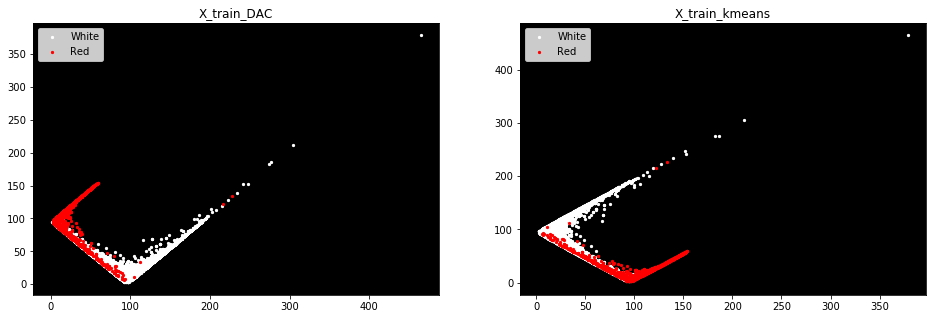

In [39]:
nightmode = True

if nightmode:
    bgc = 'black'
    fgc = 'white'
else:
    fgc = 'black'
    bgc = 'white'

plot_alpha = 1
plot_s = 5

white_idx = y_train == 'white'
red_idx = y_train == 'red'
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor(bgc)
ax1.scatter(X_train_DAC[white_idx,0], X_train_DAC[white_idx,1], s=plot_s, c=fgc, alpha=plot_alpha, label='White')
ax1.scatter(X_train_DAC[red_idx,0], X_train_DAC[red_idx,1], s=plot_s, c='red', alpha=plot_alpha, label='Red')
ax1.legend()
ax1.set_title('X_train_DAC')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor(bgc)
ax2.scatter(X_train_kmeans[white_idx,0], X_train_kmeans[white_idx,1], s=plot_s, c=fgc, alpha=plot_alpha, label='White')
ax2.scatter(X_train_kmeans[red_idx,0], X_train_kmeans[red_idx,1], s=plot_s, c='red', alpha=plot_alpha, label='Red')
ax2.legend()
ax2.set_title('X_train_kmeans')
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>
<ul style="background-color:#adebad;">
        <li>
            Fit and transform X_train with DAC(n_clusters=3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.
        </li>
    </ul>
</p>

In [ ]:
%%time
scores = []
for n_clusters in range(3,10):
    print('Transforming for',n_clusters,'clusters')
    DAC = DeterministicAnnealingClustering(n_clusters=n_clusters, random_state=42)
    DAC.fit(X_train)
    svm_DAC = skl.svm.SVC(random_state=42, gamma='auto')
    svm_DAC.fit(DAC.transform(X_train), y_train)
    scores.append([n_clusters, svm_DAC.score(DAC.transform(X_test), y_test)])
scores = np.array(scores)

In [23]:
# Scores from an example run, can be used if the code above takes too long to run
scores_ = np.array([[3., 0.90744467],[4., 0.90945674],[5., 0.91146881],[6., 0.91348089],[7., 0.90945674],[8., 0.90945674],[9., 0.90945674]])

In [ ]:
plt.bar(scores[:,0], scores[:,1])
plt.ylim((.90,.92))
plt.show()

<ul style="background-color:#adebad;">
        <li>
            Produce a phase diagram plot of the expected distortion D, as shown in figure 2 of reference [1]. For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
        </li>
    </ul>
</p>

Phase diagram below shows the variation of $\log[D / D_{min} ]$ over $\log[\beta / \beta_{min} ]$, where $D$ is the distortion and $\beta = 1/T$. I found it easier to keep track of the effective number of clusters by observing the cluster splits, as we only introduce a new cluster if need be. That means, system does not have more than effective number of clusters for any temperature. Dashed black lines denote the cluster splitting temperatures and the algorithm always begins with only one cluster. Curious reader can still get the number of effective clusters for a given iteration (temperature) through *n_eff_clusters* attribute of the class (together with list *temp*).

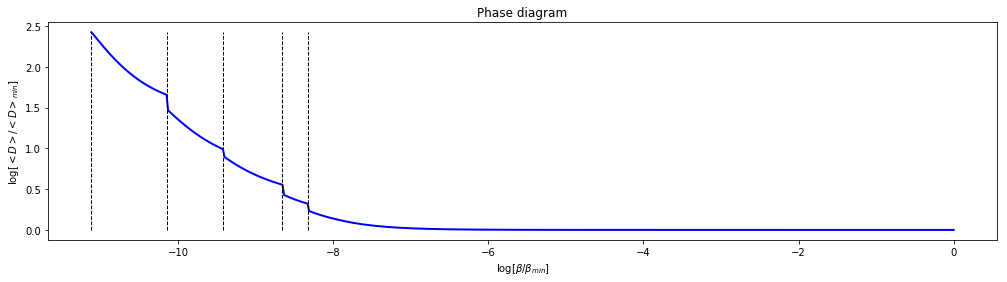

In [46]:
DAC = DeterministicAnnealingClustering(n_clusters=6, random_state=42)
DAC.fit(X_train)
DAC.phase_diagram()

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data.
        </li>
    </ul>
</p>

My reference for the difference comes from the [representations](https://ml2.inf.ethz.ch/courses/aml/slides/aml18_lecture_02.pdf) slide of the Advanced Machine Learning class. Slides 27-28 classifies scales under three groups &mdash; namely nominal, ordinal and quantitative &mdash; and further divides the quantitative scale under three sub-groups as interval, ratio and absolute scale. Interval scale is translation and scale invariant, so it only cares about the differences between measurements and the zero value is arbitrary. In ratio scale, zero value has a specific meaning but the actual measurement scale is still arbitrary. Unlike the former two, absolute scale assigns meanings to measurement values themselves (alongside the zero value, of course).  
As hinted below, Euclidean distance is incompatible with the ratio scale and the reason is that it calculates metric differences between pairs of measurements, which are scale-dependent. Calculating distance with the Euclidean metric on the same set of measurements over different scales will output proportionally different distances.

<ul style="background-color:#adebad;">
        <li>
        All the features of the wine-data set are measured on a ratio scale, which is incompatible with the euclidian metric (Remark: this is not the complete answer to problem 6, argue why they are not compatible). A more appropriate distance is proposed in reference [2]:
            <br><br>
            $d(x,y)=\log{ \frac{1}{d^2} \sum_{i,j=1}^d \frac{x_i}{x_j} \frac{y_j}{y_i}}$
            <br><br>
            Extend DAC.fit to the case of metric == ratioscale, using d(x,y) as given above.<br>
            Hint: As this distance does not give a closed form update formula for the centroids $y$, you will need to do gradient descent to update the centroids. You can either calculate the gradient by hand, or use an automatic differentiation tool like Tensorflow. If you calculate the gradient by hand, provide the formula in Latex below.
        </li>
        <li>
        Perform experiments to compare the euclidian and ratioscale metrics.
    </li>
</ul>


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot as shown on slide 19 of lecture 3. As our data is not 1-dimensional as in the lecture slide, we will have to adapt our scheme, so that the distances between nodes of the tree make sense.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation\_tree\_. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
    </ul>

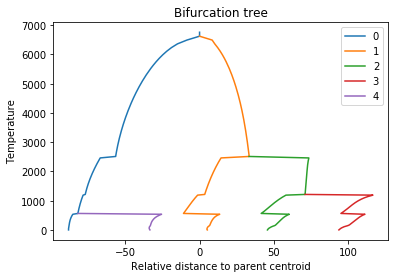

Wall time: 1min 7s


In [85]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=5, random_state=42)
DAC.fit(X_train)
DAC.plot_bifurcation()

<ul style="background-color:#adebad;">
        <li>
        Argue how reasonable our method of plotting the bifurcation is. Explain how the 1D-distances between nodes (i.e. nodes that are not siblings) do not correspond exactly to the distances between centroids. Suggest ideas for improvement.
        </li>
    </ul>

Our method of calculating distance of the nodes is only relevant when we compare to children which are the immediate result of the same split. Even then it might not be theoretically accurate as we alwasy force the distances to be of different signs. As a result of having relative distances to immediate parents, plot lacks global context. A split may result in two siblings becoming distant from each other and this may be well illustrated by our plot. However, even if successive splits may bring clusters closer to each other, their distances in the bifurcation plot may actually increase as they go away from their immediate parent centroids. Additionally, with larger number of clusters it is easy to have many overlappigng branches in the bifurcation tree.  
Although the problem is an ill-posed one, we can suggest other approaches which could be preferable for different instantiations of the algorithm over different distributions. One attempt to incoroprate the global context could be to use an absolute distance and an intuitive choice would be the use the distance to initial mean centroid. Such an approach is illustrated in the [lecture](https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture04.pdf), through slides 19-23. Such an approach may represent such cases as the aforementioned one better, but it obviously fails to correctly illustrate lot of other scenarios where two clusters move near separate points that are approximately of equal distance to the initial centroid. One other attempt could be to calculate pairwise distances between each pairs of clusters then to reorder them such that proportions of pairwise distances are similar to actual distances with respect to some other similarity metric (or a loss function).

<ul style="background-color:#adebad;">
    <li>
        First create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Then run the DAC algorithm on the wine-data set for different n_clusters. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

Below two cells respectively create the auxiliary functions to be used when plotting the quality values and extract the label indices for both color and quality attributes of the data.

In [76]:
rgb_blue = (0, 0, 1)
rgb_red = (1, 0, 0)
rgb_yellow = (1, 1, 0)

def colfunc(val, minval, maxval, startcolor, stopcolor):
    f = float(val-minval) / (maxval-minval)
    return tuple(f*(b-a)+a for (a, b) in zip(startcolor, stopcolor))

def red_blue_scale(steps):
    minval, maxval = 0.0, 1.0
    incr = (maxval-minval)/steps
    colors = []
    for i in range(steps+1):
        val = minval + round(i*incr, 1)
        colors.append(colfunc(val, minval, maxval, rgb_blue, rgb_red))
    return colors

In [77]:
white_idx = y["color"] == 'white'
red_idx = y["color"] == 'red'
whites = np.where(white_idx == True)[0]
reds = np.where(red_idx == True)[0]
n_quality = np.unique(y["quality"]).size
idx_colors = red_blue_scale(n_quality)
q_idx = {}
for idx in range(1,n_quality+1):
    #q_idx[idx] = y["quality"] == idx
    q_idx[idx] = np.where(y["quality"] == idx)[0]

*plot_embedding* function takes a 2D embedding of the data as argument and plots it over both labels. *DAC_on_embedding* takes as argument the 2D embedding, number of clusters and the desired label and outputs one plot per cluster. Each output shows the most probable data points for that cluster, labeled accordingly to the provided attribute (i.e. color or quality). I found this to be a better representative than the suggested approach of using different markers for different clusters, as it becomes hard to distinguish even 2 clusters with the abundance of the data and space limitations. Variables below control the properties of the plots, as well as the *noticks* argument of the functions. Reader can also easliy experiment with other number of clusters as *DAC_on_embedding* can calculate probabilities through DAC if they are not externally provided.

In [74]:
pa = 1    # alpha
ps = 5   # size
pm = "."  # marker
qbg = 'black'

def plot_embedding(X_embed, noticks=True):
    fig = plt.figure(figsize=(16,4))
    plt.suptitle('Data on embedding space', y=1.02)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_facecolor('white')
    ax1.scatter(X_embed[white_idx,0], X_embed[white_idx,1], marker=pm, s=ps, c='black',alpha=pa, label='White')
    ax1.scatter(X_embed[red_idx,0], X_embed[red_idx,1], marker=pm, s=ps, c='red', alpha=pa, label='Red')
    ax1.legend()
    ax1.set_title('Color')
    ax1.set_xlim((xmin,xmax))
    ax1.set_ylim((ymin,ymax))
    if(noticks):
        plt.xticks([])
        plt.yticks([])
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_facecolor(qbg)
    for idx in np.unique(y["quality"]):
        ax2.scatter(X_embed[q_idx[idx],0], X_embed[q_idx[idx],1], 
                    marker=pm, s=ps, c=[idx_colors[idx-1]], alpha=pa, label=str(idx))
    ax2.legend()
    ax2.set_title('Quality')
    ax2.set_xlim((xmin,xmax))
    ax2.set_ylim((ymin,ymax))
    if(noticks):
        plt.xticks([])
        plt.yticks([])
    plt.show()

def DAC_on_embedding(X_embed, n_clusters, cluster_probas=None, noticks=True, labels='color'):
    if cluster_probas is None:
        DAC = DeterministicAnnealingClustering(n_clusters=n_clusters, random_state=42)
        DAC.fit(X)
        cluster_probas = DAC.cluster_probabs_
        
    max_probas = np.argmax(cluster_probas, axis=1)
    clusters = {}
    for cid in range(n_clusters):
        clusters[cid] = np.where(max_probas == cid)[0]

    fig = plt.figure(figsize=(16,4))
    plt.suptitle('DAC with ' + str(n_clusters) + ' clusters, labeled by ' + labels, y=1.02)
    for cid in range(n_clusters):
        ax = fig.add_subplot(1, n_clusters, cid+1)
        if labels == 'color':
            ax.set_facecolor('white')
            ax.scatter(X_embed[np.intersect1d(whites,clusters[cid]),0], X_embed[np.intersect1d(whites,clusters[cid]),1], 
                       marker=pm , s=ps, c='black', alpha=pa, label='White')
            ax.scatter(X_embed[np.intersect1d(reds,clusters[cid]),0], X_embed[np.intersect1d(reds,clusters[cid]),1], 
                       marker=pm , s=ps, c='red', alpha=pa, label='Red')
        if labels == 'quality':
            ax.set_facecolor(qbg)
            for idx in np.unique(y["quality"]):
                ax.scatter(X_embed[np.intersect1d(q_idx[idx],clusters[cid]),0], 
                           X_embed[np.intersect1d(q_idx[idx],clusters[cid]),1], 
                       marker=pm, s=ps, c=[idx_colors[idx-1]], alpha=pa, label=str(idx))
        ax.legend()
        ax.set_title('Cluster ' + str(cid+1))
        ax.set_xlim((xmin,xmax))
        ax.set_ylim((ymin,ymax))
        if(noticks):
            plt.xticks([])
            plt.yticks([])
    plt.show()

We only run the algorithms once and use their results below.

In [51]:
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42)
DAC.fit(X)
cluster_probas2 = DAC.cluster_probabs_
DAC = DeterministicAnnealingClustering(n_clusters=4, random_state=42)
DAC.fit(X)
cluster_probas4 = DAC.cluster_probabs_

In [50]:
X_tsne = TSNE(n_components=2).fit_transform(X)
X_lle = LocallyLinearEmbedding(n_components=2).fit_transform(X)

I first tried the famous t-SNE embedding to illustrate the wine dataset in 2D. We can see an almost separate, natural cluster of red-colored wines, although some samples from both red and white colors can be seen as dispersed into each cluster. Second plot shows the quality attributes of the data points, where the ratings are colored as a transition from blue to red through 1 to 9 rating scale. It is hard to find such a semantic relationship in the spatiality of the embedding and the quality of the wines, although it could be argued that there are spatial groups that have tendencies over different intervals in the quality scale. Clustering results are discussed below.

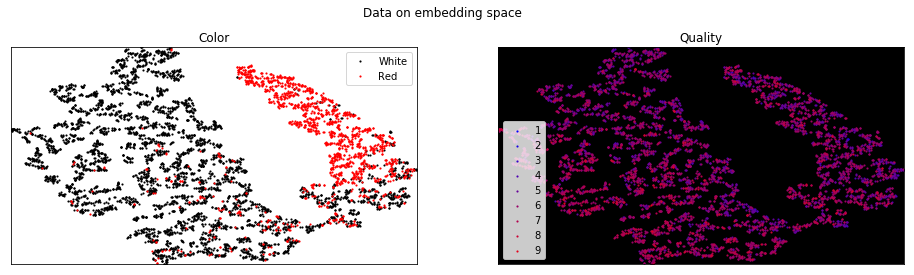

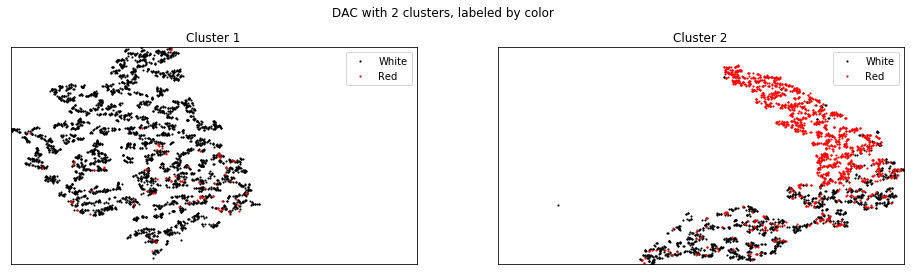

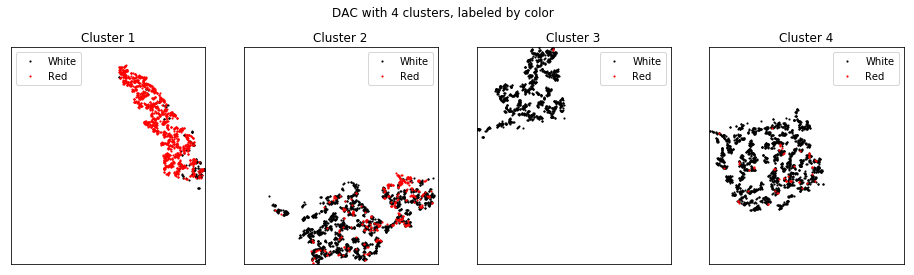

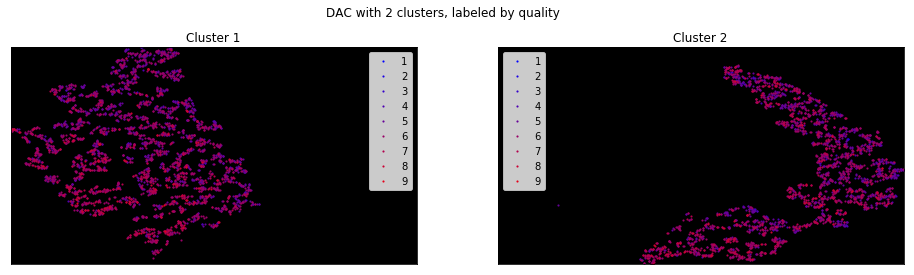

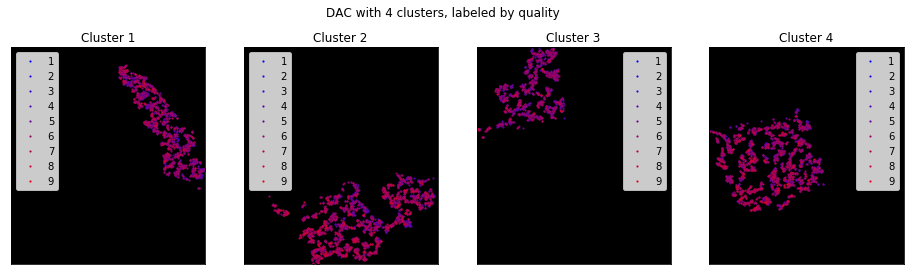

In [78]:
X_embed = X_tsne
xmin = np.min(X_embed[:,0])
xmax = np.max(X_embed[:,0])
ymin = np.min(X_embed[:,1])
ymax = np.max(X_embed[:,1])
plot_embedding(X_embed)
DAC_on_embedding(X_embed, 2, cluster_probas2)
DAC_on_embedding(X_embed, 4, cluster_probas4)
DAC_on_embedding(X_embed, 2, cluster_probas2, labels='quality')
DAC_on_embedding(X_embed, 4, cluster_probas4, labels='quality')

2-cluster DAC seems to slice the apparent red group from the data quite well, alongside some of the transition region. 4-cluster DAC outputs a finer structure where the red group is almost perfectly sliced. Similarly, we can see an almost white-exclusive cluster is separated as well. One of the two other clusters seem to capture the red- and white-dominant parts of the transition region. As discussed above, it is harder to interpret the data partition with respect to the quality attribute. Aside from seemingly more heterogeneous distribution of the wine quality over data, I believe latent variables that affect the data partition most correlate more with the color attribute than the wine quality. Plot in the appendix (see below) shows the distribution of the quality across different colors, where it is hard to see any clear correlation.

I also tested the algorithm on locally linear embeddings and the results are more or less identical to one in t-SNE scenario. 2-cluster DAC seems to be splitting the red majority from the rest, while the 4-cluster splits a pair of red- and white-exclusive regions and two intermediary partitions.

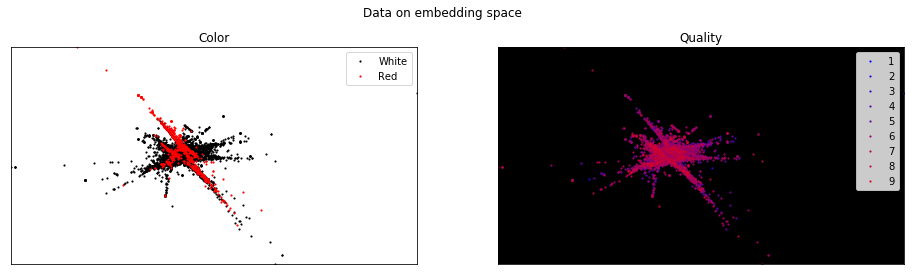

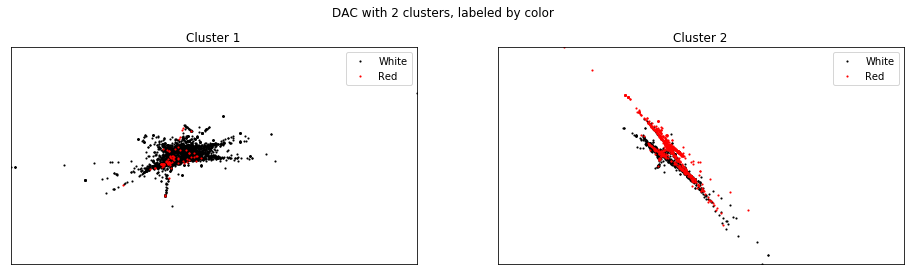

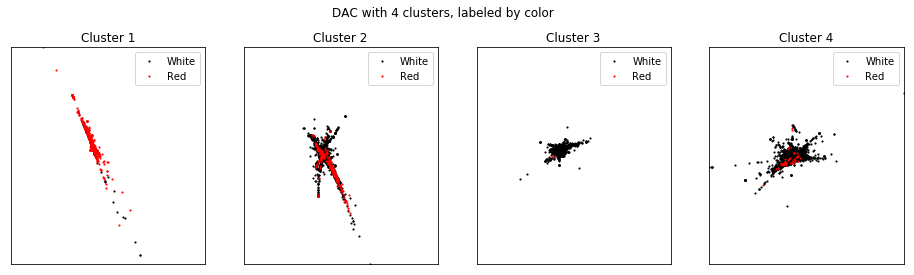

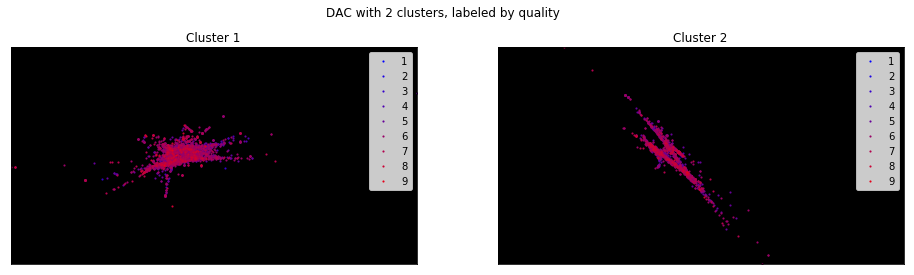

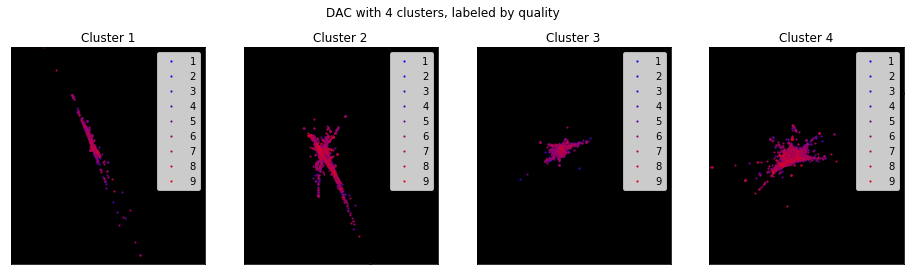

In [79]:
X_embed = X_lle
xmin = np.min(X_embed[:,0])
xmax = np.max(X_embed[:,0])
ymin = np.min(X_embed[:,1])
ymax = np.max(X_embed[:,1])
plot_embedding(X_embed)
DAC_on_embedding(X_embed, 2, cluster_probas2)
DAC_on_embedding(X_embed, 4, cluster_probas4)
DAC_on_embedding(X_embed, 2, cluster_probas2, labels='quality')
DAC_on_embedding(X_embed, 4, cluster_probas4, labels='quality')

## Appendix

Two plots below show the distribution of quality across wine colors. I preferred t-SNE implementation as it arguably illustrates the dataset in a more understandable way. 

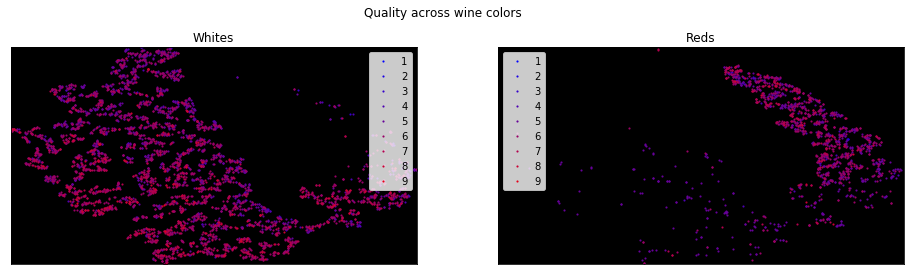

In [83]:
X_embed = X_tsne
xmin = np.min(X_embed[:,0])
xmax = np.max(X_embed[:,0])
ymin = np.min(X_embed[:,1])
ymax = np.max(X_embed[:,1])

fig = plt.figure(figsize=(16,4))
plt.suptitle('Quality across wine colors', y=1.02)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor(qbg)
for idx in np.unique(y["quality"]):
    ax1.scatter(X_embed[np.intersect1d(q_idx[idx],whites),0], X_embed[np.intersect1d(q_idx[idx],whites),1], 
                marker=pm, s=ps, c=[idx_colors[idx-1]], alpha=pa, label=str(idx))
ax1.legend()
ax1.set_title('Whites')
ax1.set_xlim((xmin,xmax))
ax1.set_ylim((ymin,ymax))
plt.xticks([])
plt.yticks([])

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor(qbg)
for idx in np.unique(y["quality"]):
    ax2.scatter(X_embed[np.intersect1d(q_idx[idx],reds),0], X_embed[np.intersect1d(q_idx[idx],reds),1], 
                marker=pm, s=ps, c=[idx_colors[idx-1]], alpha=pa, label=str(idx))
ax2.legend()
ax2.set_title('Reds')
ax2.set_xlim((xmin,xmax))
ax2.set_ylim((ymin,ymax))
plt.xticks([])
plt.yticks([])
plt.show()

Here is a toy dataset I used to validate my methods. In such clear examples, our method of constructing the bifurcation tree becomes more intutive than before.

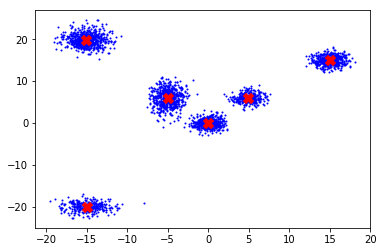

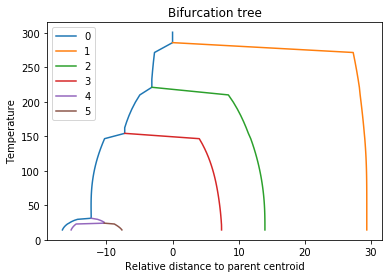

Wall time: 2.89 s


In [84]:
%%time
# Testing on toy dataset
if(True):
    xs, ys = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 500).T
    c1 = np.stack((xs,ys), axis=1)
    xs, ys = np.random.multivariate_normal([5, 6], [[1, 0], [0, 1]], 300).T
    c2 = np.stack((xs,ys), axis=1)
    xs, ys = np.random.multivariate_normal([-5, 6], [[1, 0], [0, 4]], 600).T
    c3 = np.stack((xs,ys), axis=1)
    
    xs, ys = np.random.multivariate_normal([15, 15], [[1, 0], [0, 1]], 500).T
    c4 = np.stack((xs,ys), axis=1)
    xs, ys = np.random.multivariate_normal([-15, 20], [[2, 0], [0, 2]], 600).T
    c5 = np.stack((xs,ys), axis=1)
    xs, ys = np.random.multivariate_normal([-15, -20], [[3, 0], [0, 1]], 300).T
    c6 = np.stack((xs,ys), axis=1)
    
    toy = np.concatenate((c1,c2,c3,c4,c5,c6), axis=0)

    toyDAC = DeterministicAnnealingClustering(n_clusters=6, random_state=42, T_cutoff=15, eta=0.95)
    toyDAC.fit(toy)
    toy_t = toyDAC.transform(toy)

    if(True):
        plt.scatter(toy[:,0], toy[:,1], s=1, c='blue', alpha=1)
        plt.scatter(toyDAC.cluster_centers_[:,0], toyDAC.cluster_centers_[:,1], s=100, c='red', alpha=1, marker="X")
        plt.show()
    toyDAC.plot_bifurcation()

<h2 style="background-color:#4286f4;"> Comments </h2>

Let us know what you liked about this exercise, and what we can improve!